# Creating A Facial Detection and Recognition Model
# Idris Nemsia
In this program, I build and train a Siamese Neural Network for attendance recording. Below are the references I used while building this program.
## References
To build my model, I have consulted some references to guide my coding process.
[1] : J. Loy. Implementing a Facial Recognition System with Neural Networks. Neural Network Projects with Python. Packt Publishing, February 2019.
[2] : N. Renotte. Build a Facial Recognition App // Deep Learning Project // Paper2Code Series. https://www.youtube.com/playlist?list=PLgNJO2hghbmhHuhURAGbe6KWpiYZt0AMH. 2021. 


## Initial Preparations Section
These section includes the installation of some of our needed modules. It also imports the modules we will be using.

In [1]:
# Installing Tensorflow and opencv
# !pip install --user tensorflow==2.10.1 opencv-python
#!pip install keras

In [2]:
# Imports
import cv2
import os
import numpy as np
import tensorflow as tf
import pandas as pd
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input
import matplotlib.pyplot as plt

## Loading our data

In [3]:
#matchPairsTrainFile = pd.read_csv(r'./archive/matchpairsDevTrain.csv', sep =",")
#mismatchParisTrainFile = pd.read_csv(r'./archive/mismatchpairsDevTrain.csv', sep =",")
#matchPairsTrainData = matchPairsTrainFile.to_numpy()
#mismatchPairsTrainData = mismatchParisTrainFile.to_numpy()

#matchPairsTestFile = pd.read_csv(r'./archive/matchpairsDevTest.csv', sep =",")
#mismatchParisTestFile = pd.read_csv(r'./archive/mismatchpairsDevTest.csv', sep =",")
#matchPairsTestData = matchPairsTestFile.to_numpy()
#mismatchPairsTestData = mismatchParisTestFile.to_numpy()

# Loading data
#x1DataTrain, x2DataTrain, yDataTrain = loadData(matchPairsTrainData, mismatchPairsTrainData) 
#x1DataTest, x2DataTest, yDataTest = loadData(matchPairsTestData, mismatchPairsTestData)

# Convert to numpy arrays
#x1DataTrain = np.array(x1DataTrain)
#x2DataTrain = np.array(x2DataTrain)
#yDataTrain = np.array(yDataTrain)

#x1DataTest = np.array(x1DataTest)
#x2DataTest = np.array(x2DataTest)
#yDataTest = np.array(yDataTest)

# Test, checking length
#print(len(x1DataTest))

In [4]:
from sklearn.datasets import fetch_lfw_pairs
training_data = fetch_lfw_pairs(subset="train", resize=1)
testing_data = fetch_lfw_pairs(subset="test", resize=1)

In [5]:
# Getting pairs and labels
# Training data
X_pair_train = training_data.pairs
X_pair_train = X_pair_train.astype("float32")
y_train = 1 - training_data.target.astype("float32")

# Adding the channel dimension for the training images
X1_train = np.expand_dims(X_pair_train[:, 0], axis=-1)  # First image in pairs
X2_train = np.expand_dims(X_pair_train[:, 1], axis=-1)  # Second image in pairs

# Testing data
X_pair_test = testing_data.pairs
X_pair_test = X_pair_test.astype("float32")
y_test = 1 - training_data.target.astype("float32")

# Adding the channel dimension for the testing images
X1_test = np.expand_dims(X_pair_test[:, 0], axis=-1)  # First image in pairs
X2_test = np.expand_dims(X_pair_test[:, 1], axis=-1)  # Second image in pairs



In [6]:
# Getting image shape
img = X1_train[0]
IMG_SHAPE = img.shape
print(IMG_SHAPE)


(125, 94, 1)


## Creating our Model
### Creating the feature generating model
The layers of this section follow the layers explained in [2]. However, more modifications will be made to this code as Max Pooling layers are incomplete. This is causing the loss value to be NaN during the training of my model.

In [7]:
feature_generation_network = Sequential()
feature_generation_network.add(Conv2D(filters=32, kernel_size=(10,10), activation='relu', input_shape=IMG_SHAPE))
feature_generation_network.add(MaxPooling2D(padding="same"))
feature_generation_network.add(Conv2D(filters=64, kernel_size=(7,7), activation='relu'))
feature_generation_network.add(MaxPooling2D(padding="same"))
feature_generation_network.add(Conv2D(filters=128, kernel_size=(4,4), activation='relu'))
feature_generation_network.add(MaxPooling2D(padding="same"))
feature_generation_network.add(Flatten())
feature_generation_network.add(Dense(units=1024, activation="sigmoid"))

In [8]:
# Plot the feature generation network 
#tf.keras.utils.plot_model(feature_generation_network, show_shapes=True)

In [9]:
# Get the summary of the structure of the model
feature_generation_network.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 116, 85, 32)       3232      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 58, 43, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 52, 37, 64)        100416    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 26, 19, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 23, 16, 128)       131200    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 8, 128)       0

### Defining the inputs and outputs
The outputs here refer to the network used to generate features inside our siamese neural network for each input. The two outputs of the feature_generation_network from input1 and input2 will then be compared by calculating the Euclidean distance between them.

In [10]:
input1, input2 = Input(shape=IMG_SHAPE, name="Image1"), Input(shape=IMG_SHAPE, name="Image2")
# Share the single output layer for both inputs
output1, output2 = feature_generation_network(input1), feature_generation_network(input2)

## Defining the output of the siamese_network: Distance between our two inital outputs

In [11]:
# References [1]
from helper_functions import euclidean_distance
from keras.layers import Lambda
# Creating the final layer of the SNN
distance_layer = Lambda(euclidean_distance, output_shape=(1,))([output1, output2])
#final_output = Dense(1, activation='sigmoid')(distance_layer)

### Initialize Siamese Neural Network Model with inputs and outputs

In [12]:
siamese_network = Model((input1, input2), distance_layer)


### Get Summary of our model

In [13]:
siamese_network.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Image1 (InputLayer)            [(None, 125, 94, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Image2 (InputLayer)            [(None, 125, 94, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 sequential (Sequential)        (None, 1024)         12818784    ['Image1[0][0]',                 
                                                                  'Image2[0][0]']             

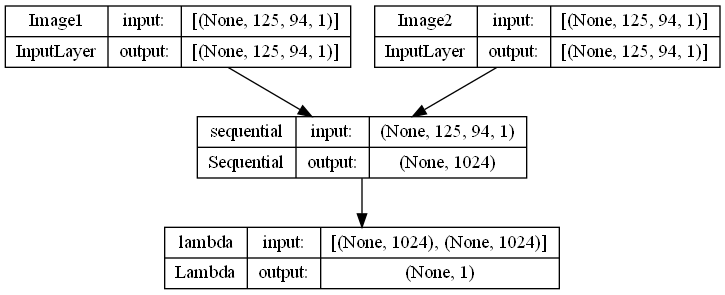

In [14]:
# Plot Siamese Neural Network Structure
tf.keras.utils.plot_model(siamese_network, show_shapes=True)

## Training our model

### Compile our model

In [15]:
#from helper.snn_functions import contrastive_loss
from keras.optimizers import Adam
from keras import backend as K

def contrastive_loss(Y_true, D):
    margin = 1
    return K.mean((1 - Y_true) * K.square(D) + (Y_true) * K.square(K.maximum(margin - D, 0)))

siamese_network.compile(
    loss=contrastive_loss, 
    optimizer=Adam(learning_rate=0.001), 
    metrics=["accuracy"]
)

In [16]:
# Choosing a small sample from the training data
size_train = len(X1_train)
random_indices = np.random.choice(size_train, 2000, replace=False)
print(f"random_indices={random_indices}")
X1_train_subset = X1_train[random_indices]
X2_train_subset = X2_train[random_indices]
y_train_subset = y_train[random_indices]

random_indices=[ 324  391 1527 ...  249  207  613]


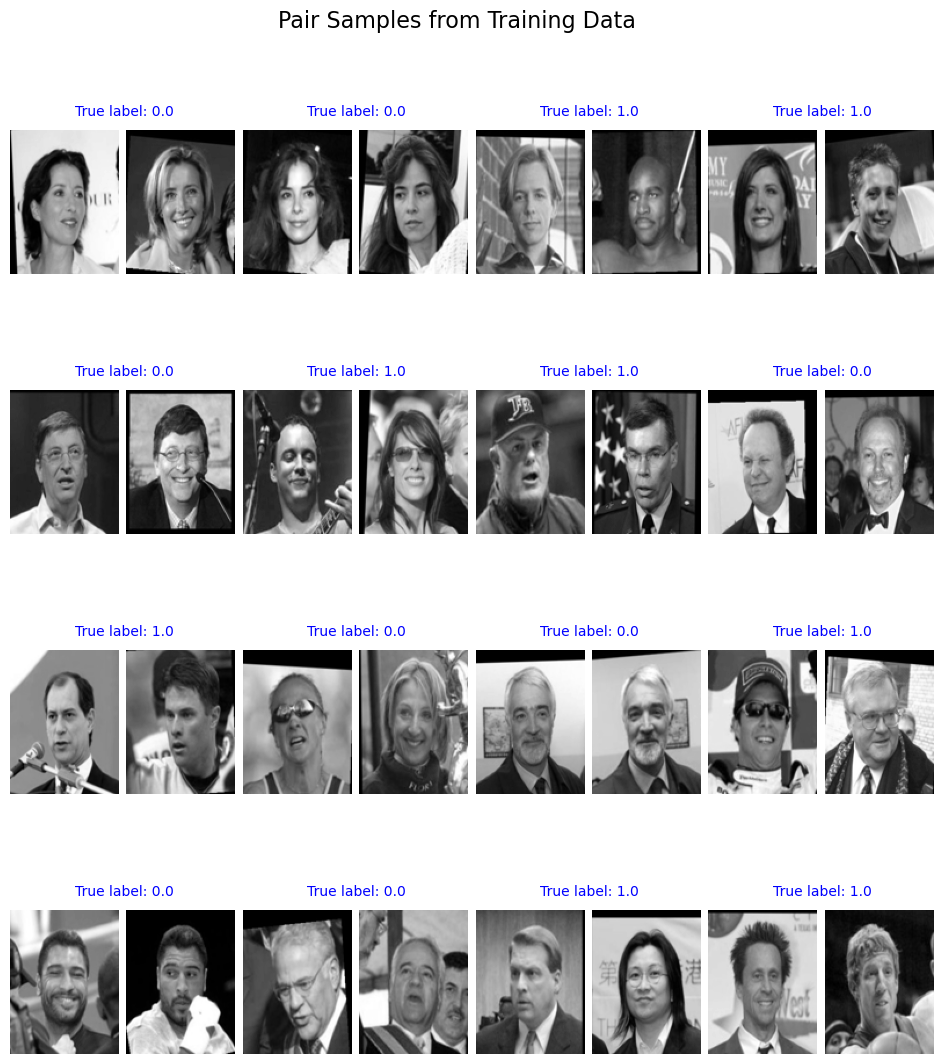

In [17]:
# Define the number of pairs to visualize and the layout
num_pairs = 16
pairs_per_row = 4
rows = num_pairs // pairs_per_row

# Create a figure with multiple subplots
fig, axes = plt.subplots(rows, pairs_per_row * 2, figsize=(12, 3 * rows))
fig.subplots_adjust(wspace=0.01, hspace=0.8)  # Minimal space between images in a pair; more between rows

# Plot each pair with its label
for i in range(num_pairs):
    row = i // pairs_per_row
    col = (i % pairs_per_row) * 2  # Each pair occupies two columns

    # Display the first image of the pair (X1_train[i])
    axes[row, col].imshow(X1_train_subset[i], cmap='gray')  # Adjust cmap as needed
    axes[row, col].axis('off')

    # Display the second image of the pair (X2_train[i])
    axes[row, col + 1].imshow(X2_train_subset[i], cmap='gray')  # Adjust cmap as needed
    axes[row, col + 1].axis('off')

    # Add the label above the pair, centered
    label = f"True label: {y_train_subset[i]}"
    axes[row, col].set_title(label, fontsize=10, color="blue", pad=10, loc='center', x=1.05)
    axes[row, col + 1].set_title("")  # Empty title for the second image in each pair

plt.suptitle("Pair Samples from Training Data", fontsize=16)
plt.show()

In [18]:
from keras import backend as K
y_train_subset_float = K.cast(y_train_subset, 'float32')
print(y_train_subset_float)

tf.Tensor([0. 0. 1. ... 0. 0. 0.], shape=(2000,), dtype=float32)


In [19]:
random_indices = np.random.choice(len(X1_test), 400, replace=False)
print(f"random_indices={random_indices}")
X1_test_subset = X1_test[random_indices]
X2_test_subset = X2_test[random_indices]
y_test_subset = y_test[random_indices]

random_indices=[257 965 877 615 536 529 163  63 141 611  70 686 313 398 819 388 216 587
 406 663 974 191  74  34 731  20 839 485 499 532 172 921 151 568 432 426
 385 744 633 261 318 234 297 248 982 467 884 745 123 589 848 458 549 359
 520 623 247 969 813 249 134 798 206 638 176 728 276 260 778 367 637 905
 850 389 513 788 378 683 618 417 348 820 181 382 233 789 530  66 722 294
 272 672 859  73 733 449 539 800 910  43 796 852 670 195 684 928  10 879
 150 810 317 695  97 609 190 454 723 113 767 522 564 312 632  22 255 205
 346 219 983 410 515 842 952 992 323 554 851 635 468 256 511 863 591 326
 855 469 616 951  60 979 293  91 507 937 984 821 586 795 419 805 535 993
 138 334 908 867 215 704  31 721 105  98 481 383 885 345 868 197 553 668
 671 299 558 934 588 344 736 277  14 801 402 803 228 847 854 128 262 772
 229 988 366 376 920 411 981 760 251 636 738 774 959 506 882 302  75 478
 943 476 525 127 565 592 869 329 214 576 693 392 393 120 574 502 124 152
 356 900 702 353 307 333 726 825 471

In [20]:
# Training the model
siamese_network.fit(x=[X1_train_subset, X2_train_subset], 
                    y = y_train_subset, 
                    batch_size = 16, 
                    epochs=30,
                    validation_data=([X1_test_subset, X2_test_subset], y_test_subset))

Epoch 1/30
125/125 [==============================] - 104s 826ms/step - loss: 0.2402 - accuracy: 0.5850 - val_loss: 0.3382 - val_accuracy: 0.3400
Epoch 2/30
125/125 [==============================] - 110s 876ms/step - loss: 0.2189 - accuracy: 0.6595 - val_loss: 0.2205 - val_accuracy: 0.6925
Epoch 3/30
125/125 [==============================] - 98s 782ms/step - loss: 0.2126 - accuracy: 0.6780 - val_loss: 0.3164 - val_accuracy: 0.4375
Epoch 4/30
125/125 [==============================] - 98s 783ms/step - loss: 0.2099 - accuracy: 0.6915 - val_loss: 0.2766 - val_accuracy: 0.4625
Epoch 5/30
125/125 [==============================] - 99s 791ms/step - loss: 0.2082 - accuracy: 0.6885 - val_loss: 0.4850 - val_accuracy: 0.1525
Epoch 6/30
125/125 [==============================] - 98s 782ms/step - loss: 0.2034 - accuracy: 0.7025 - val_loss: 0.3048 - val_accuracy: 0.4825
Epoch 7/30
125/125 [==============================] - 99s 793ms/step - loss: 0.1942 - accuracy: 0.7380 - val_loss: 0.3716 - val_

## Testing our model

In [21]:
Y_predict = siamese_network.predict([X1_test_subset,X2_test_subset])


13/13 [==============================] - 3s 185ms/step


In [22]:
# Evaluating accuracy
from sklearn.metrics import accuracy_score
Y_predict_decisions = []
for i in range(len(Y_predict)):
    if Y_predict[i] > 0.5:
        Y_predict_decisions.append(1)
    else:
        Y_predict_decisions.append(0)

# Calculate accuracy
accuracy = accuracy_score(y_test_subset, Y_predict_decisions)
print("Accuracy:", accuracy)
print(f"y_predict={Y_predict}")

Accuracy: 0.22
y_predict=[[0.796911  ]
 [0.5261539 ]
 [0.7710883 ]
 [0.48786715]
 [0.5345689 ]
 [0.59524417]
 [0.453604  ]
 [0.34233272]
 [0.7320976 ]
 [0.907975  ]
 [0.5075292 ]
 [0.52159065]
 [0.5341003 ]
 [0.7120651 ]
 [0.9485075 ]
 [0.679401  ]
 [0.39373574]
 [0.6929446 ]
 [0.51078457]
 [0.8212955 ]
 [0.77934045]
 [0.6019783 ]
 [0.8817362 ]
 [0.48217753]
 [1.0459758 ]
 [0.48158655]
 [0.49725738]
 [0.38147134]
 [0.38433373]
 [0.84649384]
 [0.5051523 ]
 [0.7262098 ]
 [0.70923954]
 [0.7786414 ]
 [0.61827606]
 [0.57564837]
 [0.46484414]
 [0.7666416 ]
 [0.4739188 ]
 [0.9245468 ]
 [0.52952284]
 [0.5690166 ]
 [0.525022  ]
 [0.7768908 ]
 [0.7957634 ]
 [0.59978175]
 [0.9072804 ]
 [0.97353023]
 [0.887565  ]
 [1.143279  ]
 [0.75738806]
 [1.0297519 ]
 [0.73867774]
 [0.5143497 ]
 [0.6891231 ]
 [0.7856581 ]
 [0.50192773]
 [0.4363665 ]
 [0.7220532 ]
 [0.6498997 ]
 [0.52061987]
 [0.60285866]
 [0.62884104]
 [0.8426565 ]
 [0.5776607 ]
 [0.48140496]
 [0.62531084]
 [0.6366615 ]
 [0.62648225]
 [0.39770

NameError: name 'x2_train_subset' is not defined

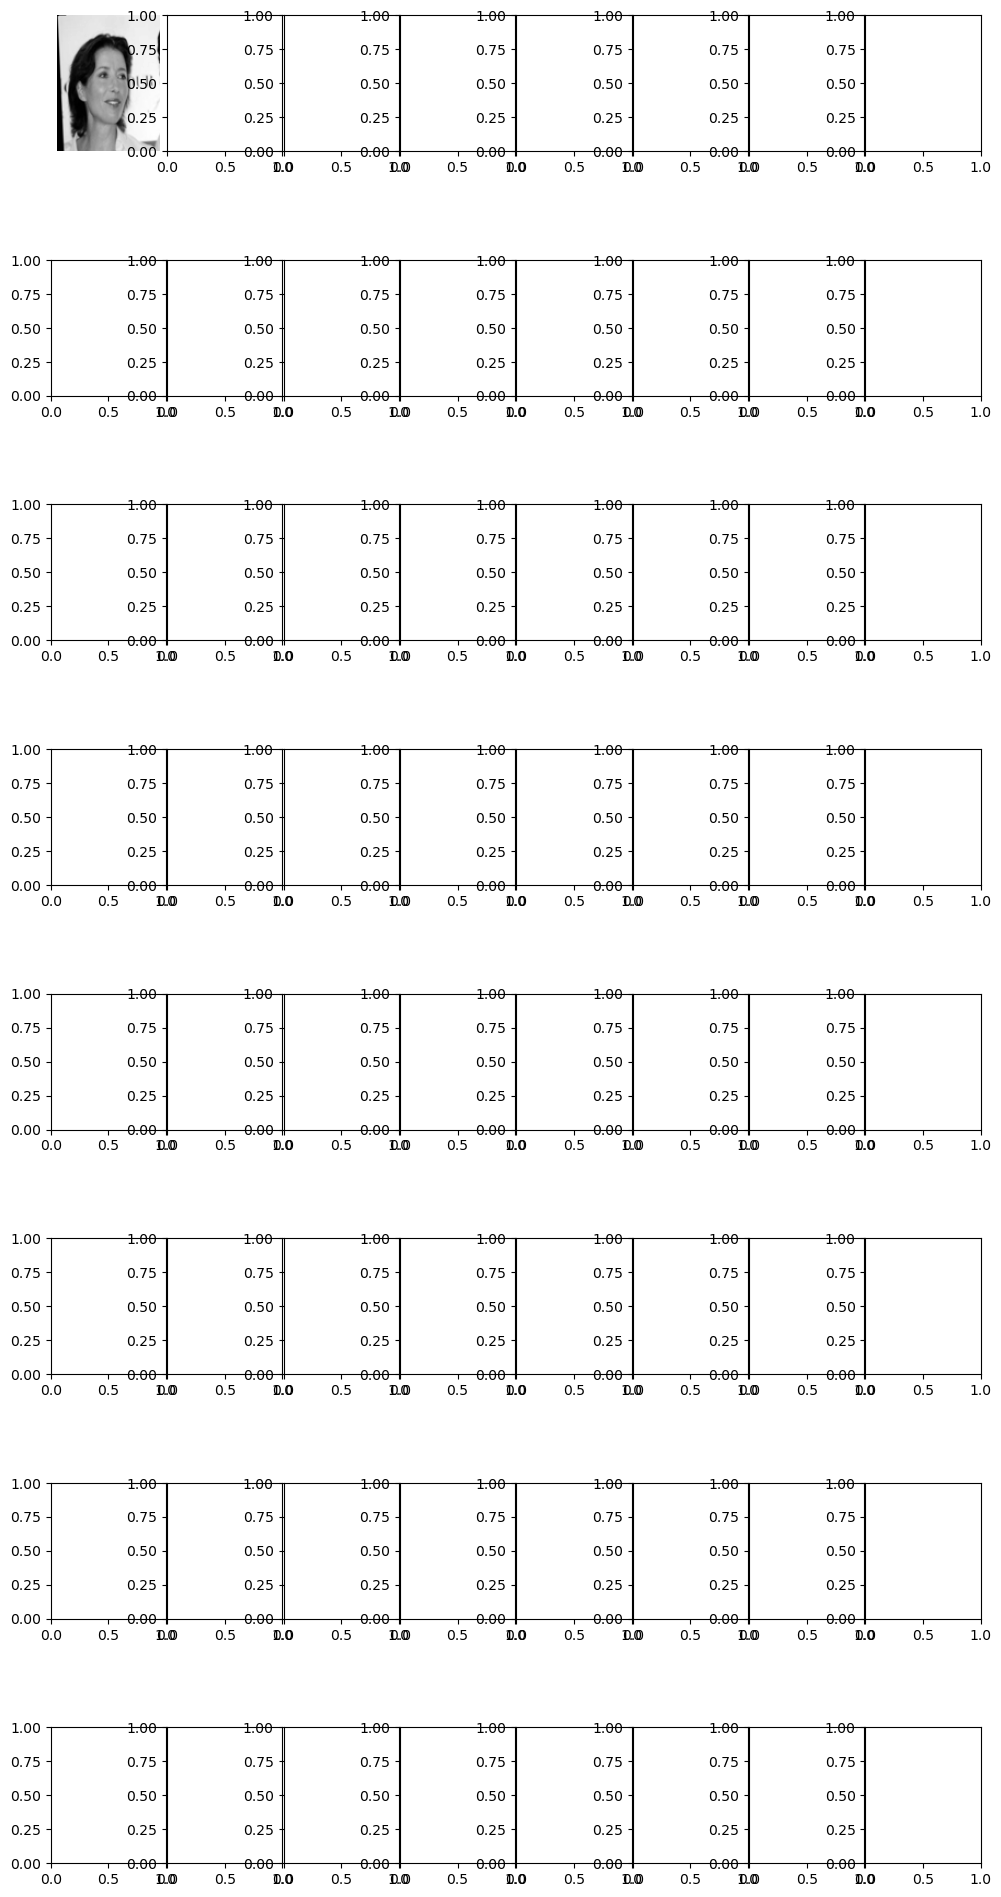

In [23]:
# Visualizing results
# Define the number of pairs to visualize and the layout
num_pairs = 32
pairs_per_row = 4
rows = num_pairs // pairs_per_row

# Create a figure with multiple subplots
fig, axes = plt.subplots(rows, pairs_per_row * 2, figsize=(12, 3 * rows))
fig.subplots_adjust(wspace=0.01, hspace=0.8)  # Minimal space between images in a pair; more between rows

# Plot each pair with its label
for i in range(num_pairs):
    row = i // pairs_per_row
    col = (i % pairs_per_row) * 2  # Each pair occupies two columns

    # Display the first image of the pair (X1_train[i])
    axes[row, col].imshow(X1_train_subset[i], cmap='gray')  # Adjust cmap as needed
    axes[row, col].axis('off')

    # Display the second image of the pair (X2_train[i])
    axes[row, col + 1].imshow(x2_train_subset[i], cmap='gray')  # Adjust cmap as needed
    axes[row, col + 1].axis('off')

    # Delete
    toPrint = "same"
    if(Y_predict[i] < 0.5):
        toPrint = "different"
    # Add the label above the pair, centered
    label = f"Prediction: {toPrint}"
    axes[row, col].set_title(label, fontsize=10, color="blue", pad=10, loc='center', x=1.05)
    axes[row, col + 1].set_title("")  # Empty title for the second image in each pair

plt.suptitle("Pair Samples from Training Data", fontsize=16)
plt.show()

## Saving our model
This part was causing me errors. The model was not getting saved correctly and I could not load it in another file. This is why I continued my work in this file instead of using a more structured file structure.

In [ ]:
#siamese_network.save("siamese_network.h5")

# Creating an interface to test our model

In [ ]:
import tensorflow as tf
import random
import numpy as np
from keras import backend as K
import cv2


Distance (similar): [[0.1414213]]
Distance (dissimilar): [[5.656854]]


In [ ]:
#from keras.models import load_model
#from helper_functions import contrastive_loss, euclidean_distance
#model = load_model('siamese_network.h5', 
#                    custom_objects={'contrastive_loss': 
#                    contrastive_loss, 
#                    'euclidean_distance':euclidean_distance,
#                    'Lambda': tf.keras.layers.Lambda})

In [ ]:
#from StudentsList import StudentsList
#from Camera import Camera
#import os
#import tensorflow as tf

#students_list = StudentsList(os.getcwd() + "/students")
#students_list.load()
#camera = Camera(students_list, siamese_network)
#op = False
#while True:
#    if not op:
#        print('''Attendance Recorder Program
#    --------------------Options-------------------
#    'a': Show list of students
#    'b': Show list of present students
#    'c': Register student
#    'd': Delete student
#    'e': Take attendance (Not functional)
#    'f': Check model accuracy
#    'g': Reset
#    'p': Quit
#    ' ': continue
#    ----------------------------------------------
#    ''')
#        
#    op = True
#    option = input('Input your option:')
#    if option == 'a':
#        for student in students_list.get_list_of_students():
#            print(student.get_name())
#    elif option == 'b':
#        for student in students_list.get_present_students():
#            print(student.get_name())
#    elif option == 'c':
#        name = input("What is the name of the student: ")
#        students_list.add_student(name)
#        camera.add_student_pictures(name)
#        print(f"Student {name} successfully registered")
#        print()
#    elif option == 'd':
#        name = input("What is the name of the student: ")
#        students_list.delete_student(name)
#        print(f"Student {name} successfully deleted")
#        print()
#    elif option == 'e':
#        print("Unfortunately, this option is currently not functional")
#        #camera.take_attendance()
#        #print(f"Present students: {students_list.get_present_students()}")
#    elif option == 'f':
#        for student in students_list:
#            student.set_attendance(False)
#    elif option == 'p':
#        break
#    elif option == ' ':
#        op = False
#    else:
#        print("Option is not valid")

